<a href="https://colab.research.google.com/github/lifewinning/MLTSA22_final/blob/main/TimeSeriesAnalysis_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 2.0 MB/s 
     |████████████████████████████████| 45 kB 1.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640379 sha256=b3988c26f101da3cd774e76447877d595cd9d0f5b7b626a32bf4136b4c0cfc80
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
import numpy as np
import pylab as pl
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet import diagnostics
from scipy import stats
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [88]:
suez = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/Suez.csv')
longbeach = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/longbeach.csv')
rotterdam = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/rotterdam.csv')
singapore = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/singapore.csv')
bayonne = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/bayonne.csv')

In [89]:
allDFs = [suez, longbeach, rotterdam, singapore, bayonne]
names = ["Suez Canal", "Long Beach", "Rotterdam", "Singapore", "Bayonne"]

In [55]:
covid = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/WHO-COVID-19-global-data.csv')

In [56]:
covid['Date_reported'] = pd.to_datetime(covid.Date_reported)
covid.rename(columns = {'Date_reported':'ds'}, inplace = True)
daily_covid = covid.groupby('ds')[['New_cases']].sum().reset_index()
daily_covid['New_cases'] = preprocessing.scale(daily_covid['New_cases'])

In [92]:
def shapeDFs(df):
  newdf = df.drop(columns = df.columns[0])
  newdf.rename(columns = {'date':'ds'}, inplace=True)
  newdf['ds'] = pd.to_datetime(newdf.ds)
  newdf['y'] = preprocessing.scale(newdf.y)
  newdf['y_err'] = preprocessing.scale(newdf.y_err)
  return newdf

In [36]:
def covidMerge(df):
  mergeDF = pd.merge(df, daily_covid,  on= 'ds', how = 'left')
  mergeDF['New_cases'] =  mergeDF['New_cases'].fillna(daily_covid.New_cases.min())
  return mergeDF

In [23]:
def makeProphetSimple(df):
  model = Prophet().fit(df[['ds','y']])
  pred = model.predict(df[['ds','y']])
  return model, pred

In [37]:
def makeProphetCovid(df): 
  model = Prophet().add_regressor('New_cases').fit(df)
  pred = model.predict(df)
  return model, pred

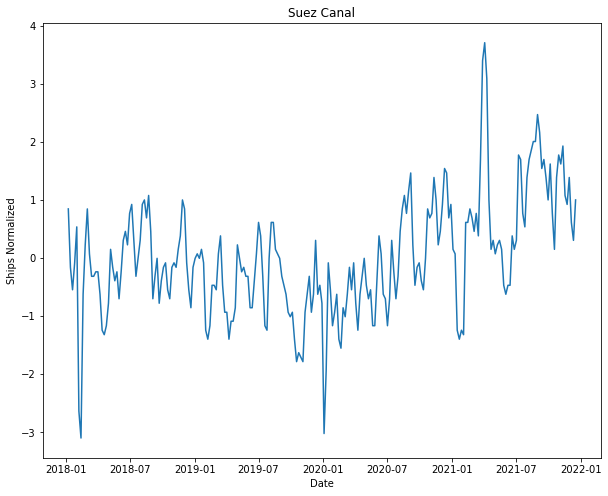

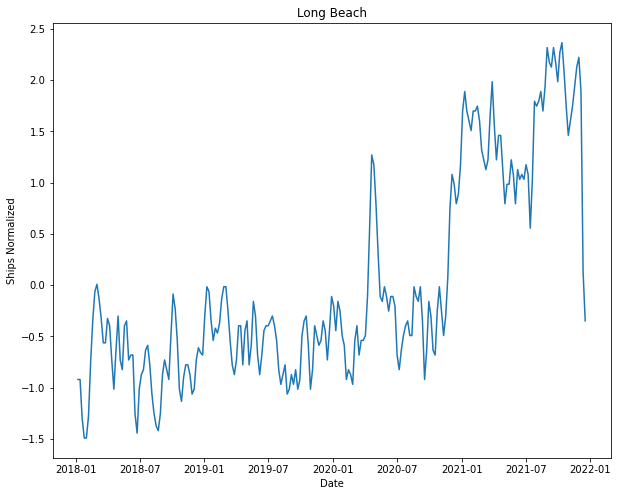

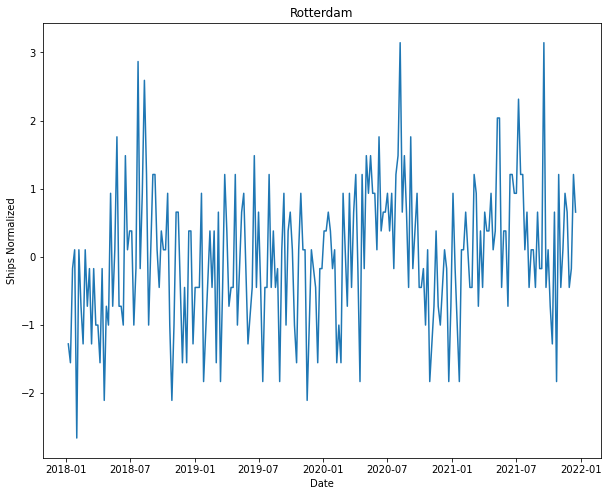

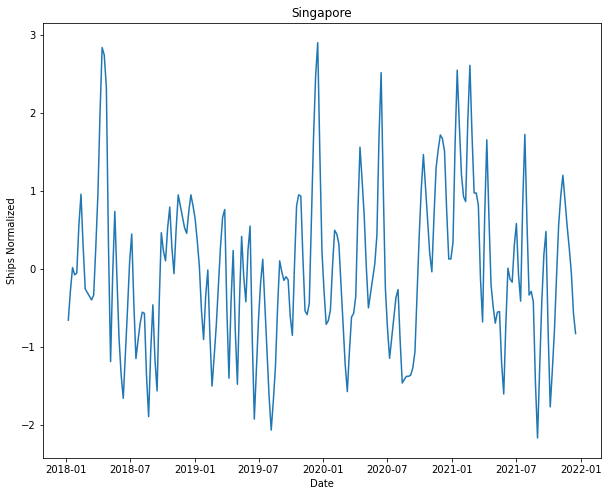

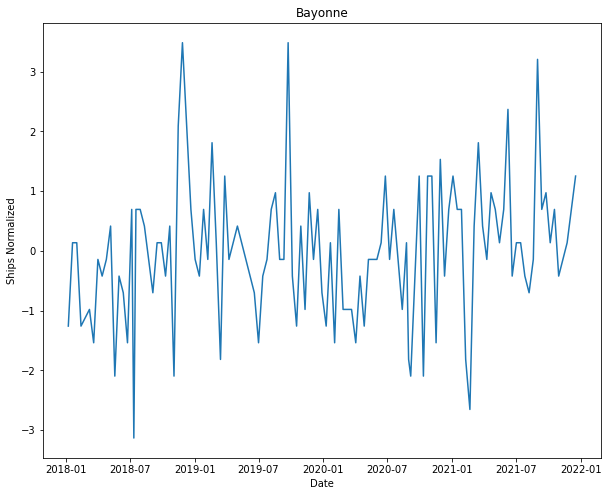

In [93]:
for i ,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  fig, ax = pl.subplots(figsize=(10, 8))
  ax.plot(basicDF['ds'], basicDF['y'])
  ax.set_xlabel('Date')
  ax.set_ylabel('Ships Normalized')
  ax.set_title('{0}'.format(names[i]))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


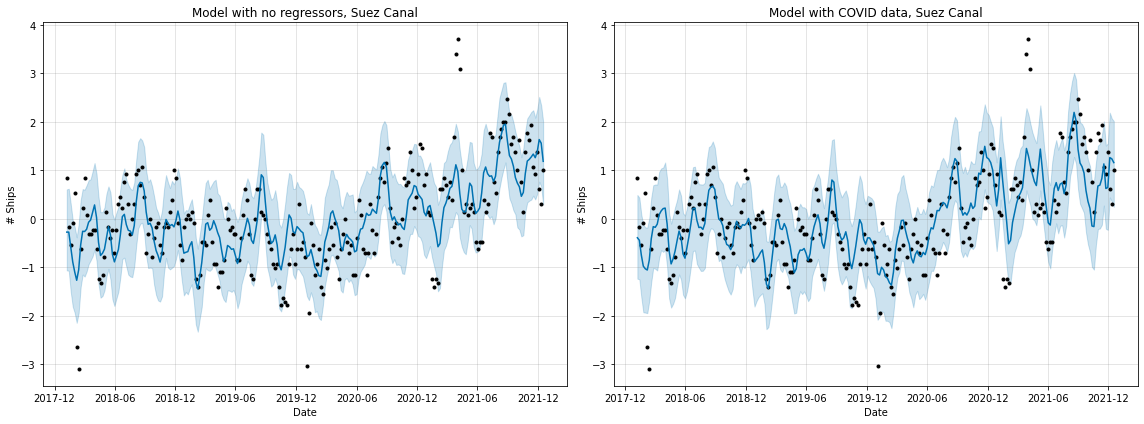

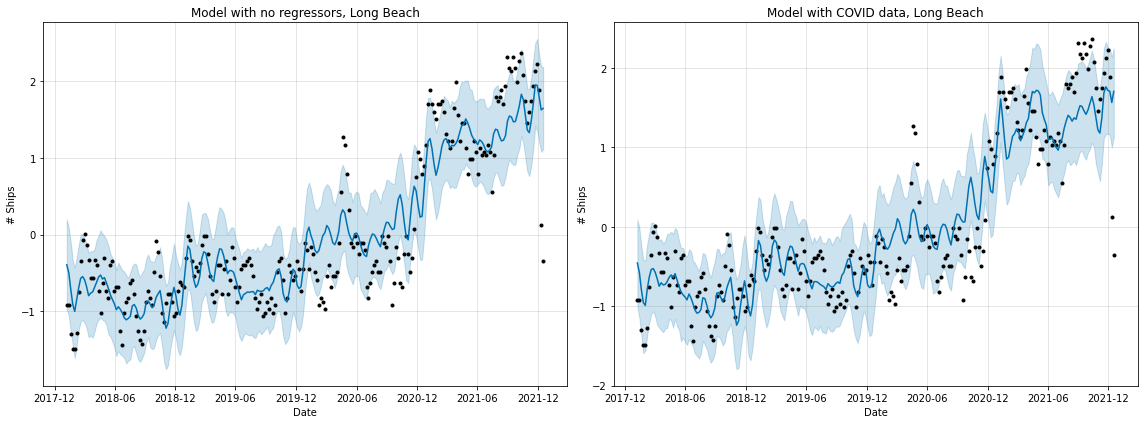

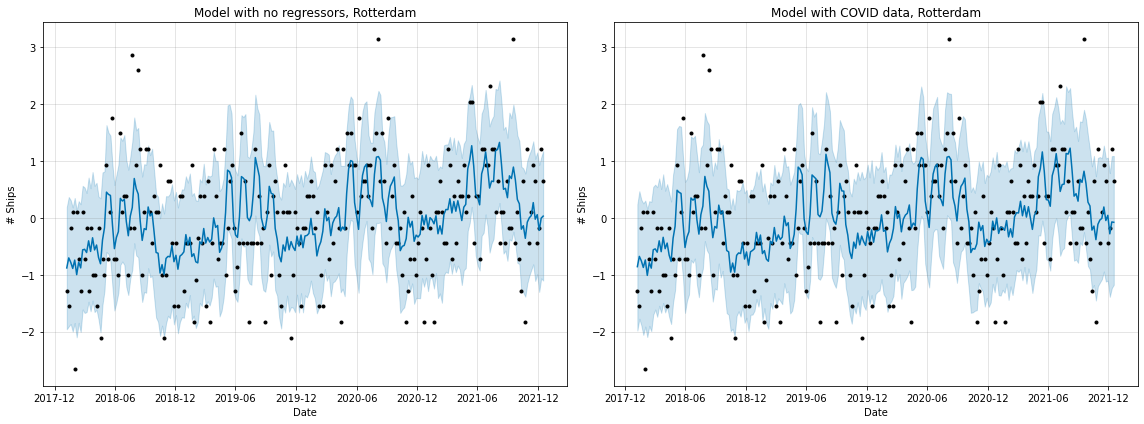

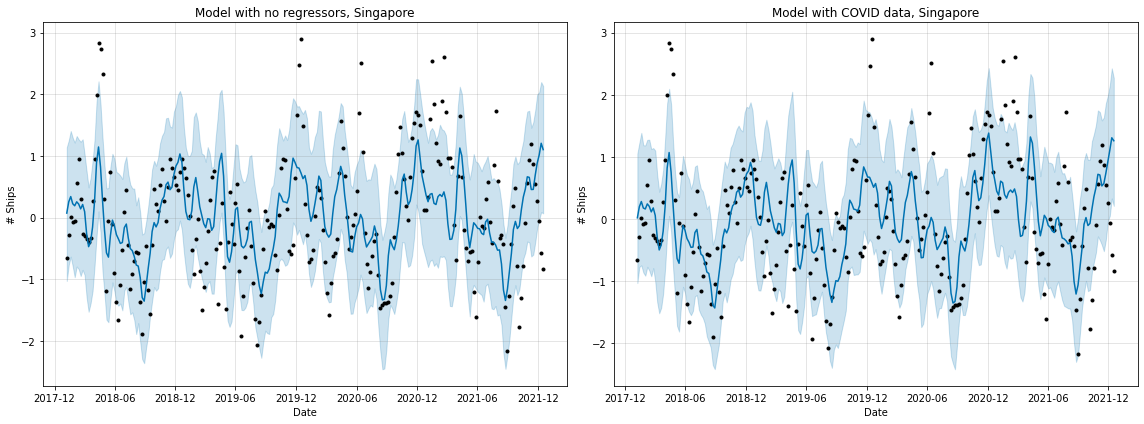

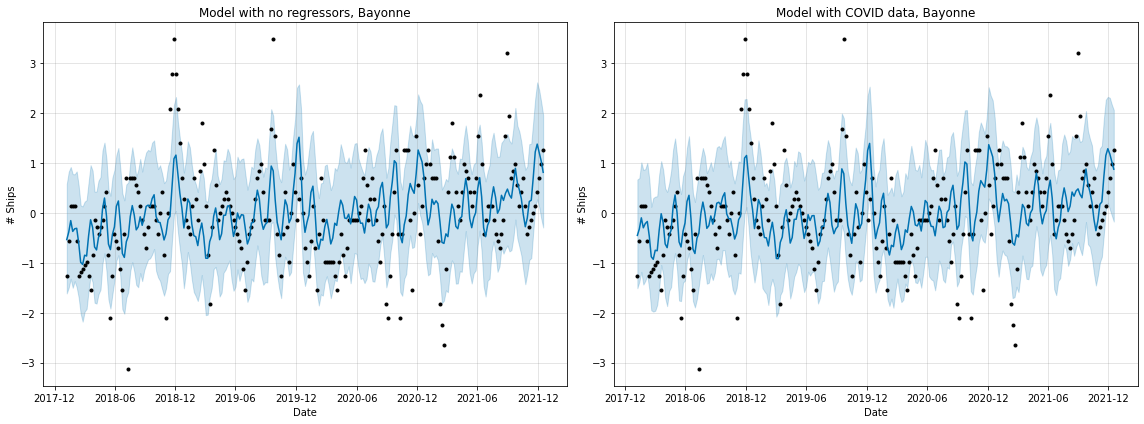

In [70]:
for i,df in enumerate(allDFs):
  fig, ax = pl.subplots(1, 2, figsize=(16, 6))
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge(basicDF)
  covidModel, covidPred = makeProphetCovid(covidDF)
  basicModel.plot(basicPred, ax=ax[0])
  ax[0].set_xlabel('Date')
  ax[0].set_ylabel('Ships Normalized')
  ax[0].set_title('Model with no regressors, {0}'.format(names[i]))
  covidModel.plot(covidPred, ax=ax[1]);
  ax[1].set_xlabel('Date')
  ax[1].set_ylabel('Ships Normalized')
  ax[1].set_title('Model with COVID data, {0}'.format(names[i]))

In [95]:
def rchi2(y, ytrue):
  return np.sum(((ytrue-y)**2)/len(ytrue))

In [101]:
def cv_rchi2(model):
  cv = diagnostics.cross_validation(model, horizon ='180 days')
  return rchi2(cv['yhat'], cv['y'])

In [102]:
for i,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge(basicDF)
  covidModel, covidPred = makeProphetCovid(covidDF)
  simpleRchi = cv_rchi2(basicModel)
  covidRchi = cv_rchi2(covidModel)
  print('Comparing reduced chi square for {0}: {1} no regressors, {2} with covid data'.format(names[i], simpleRchi, covidRchi))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Comparing reduced chi square for Suez Canal: 1.3568941115615418 no regressors, 2.5091543056944703 with covid data


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Comparing reduced chi square for Long Beach: 0.7096709463007578 no regressors, 0.929417805501751 with covid data


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Comparing reduced chi square for Rotterdam: 1.0557311550979422 no regressors, 2.8501255018247384 with covid data


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Comparing reduced chi square for Singapore: 1.390262748164121 no regressors, 3.7747549205830677 with covid data


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-01 00:00:00 and 2021-06-20 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

Comparing reduced chi square for Bayonne: 1.8708227455377326 no regressors, 3.094447875300512 with covid data


# Summarizing because just using print() is kind of sloppy here
- Suez Canal: 1.3568941115615418 no regressors, 2.5091543056944703 with covid data
- Long Beach: 0.7096709463007578 no regressors, 0.929417805501751 with covid data
- Rotterdam: 1.0557311550979422 no regressors, 2.8501255018247384 with covid data
- Singapore: 1.390262748164121 no regressors, 3.7747549205830677 with covid data
- Bayonne: 1.8708227455377326 no regressors, 3.094447875300512 with covid data
